In [76]:
import numpy as np
import matplotlib.pyplot as plt
import sdeint
import pandas as pd
import ipywidgets
from ipywidgets import Layout, interact, IntSlider
import plotly.express as px
import pickle
import pycatch22 as catch22
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import random

<img src = "resources/bistable_hysteresis.png" width=500, height=400>

## Bistable System - The Potential
For our system with equation:
$$\dot{x} = \lambda + x - x^3$$
The restoring force is given by:
$-dV/dx = \lambda + x - x^3 $. Therefore the potential function is:
$$V(x) = -\lambda x - \frac{x^2}{2} + \frac{x^4}{4}$$

In the bistable region ($\lambda = 0$), we observe a characteristic double well with two minima - corresponding to the stable lower and upper branches, and a local maxima, corresponing to the unstable branch. It is much more apparent that noise which opposes the restoring force can cause the trajectory to switch between minima resulting in bistable switching.

##### As we scan over values of $\lambda = [-1,1]$, we can get an idea of how the dynamics are governed for each value of lambda and how 'strongly' the trajectory is attracted to the stable minimum. 

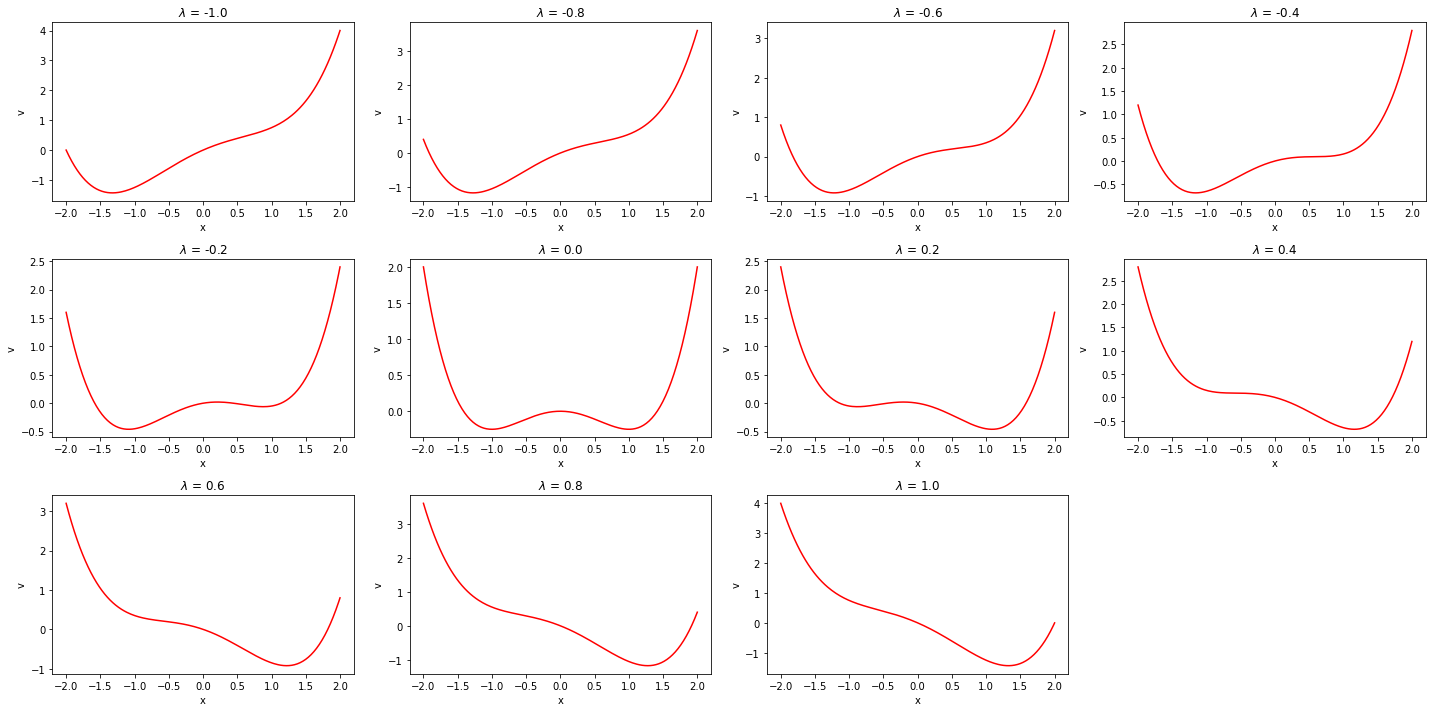

In [2]:
x = np.linspace(-2, 2, 200)
fig, axes = plt.subplots(3, 4, figsize=(20,10))
lam = np.linspace(-1,1, 11)
for lam, ax in zip(lam, axes.ravel()):
    ax.plot(x, -lam*x - (x**2)/2 + (x**4)/4, color='red')
    ax.set_title('$\lambda$ = {:.1f}'.format(lam))
    ax.set_xlabel('x')
    ax.set_ylabel('v')
axes[2, 3].axis('off')
fig.tight_layout()
plt.show()

These are the potentials we observe for low to no noise level. Thus, without stochastics, the trajectory is 'restricted' to 'exploring' the above potentials for initial conditions in the range of $x_0 = [-2, 2]$. However, as we increase the noise $\eta$ this has the same effect as increasing the range over which we define the x-values and features. For really large $\eta$, the potential will start to look like a quadratic/quartic and the finer details such as the double minima will be 'smoothed over' -> thus, the trajectory will behave as if these features were essentially non-existent (does not 'see' them) as the stochastics dominate over the behaviour governed by the deterministic component. 

**Interesting observation** - It appears as though increasing the value of $\lambda$ rotates the entire well clockwise until it is flat at $\lambda = 0$ and then continues to rotate for positive $\lambda$. Also helpful to think of a ball rolling down the potential to understand the behaviour.

In [3]:
# Observe one trajectory and see how it tracks in this potential. 

In [4]:
random.seed(454)
noise = 0.001
dt = 0.01
ic = np.array([-1])
def f(state, t):
    r = -2
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 1000, dt)
gw = lambda y, t: noise * np.identity(ic.shape[0]) # noise is relative to ic's 
fw = lambda y, t: np.array(f(y,t))
sol = sdeint.itoint(fw, gw, np.array(ic), tspan)

In [5]:
eta = int(500/dt) # remove transients
sol = sol[eta:]
min = np.min(sol)
max = np.max(sol)
med = np.median(sol)
med


-1.5213820161409515

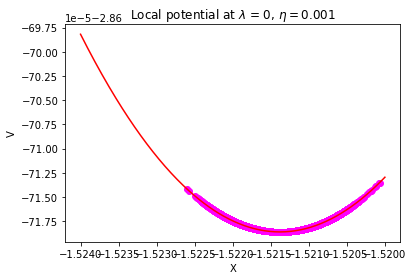

In [6]:
x = np.linspace(-1.524, -1.52, 300)
lam = -2
plt.figure(figsize=(6,4))
plt.plot(x, -lam*x - (x**2)/2 + (x**4)/4, color='red')
plt.scatter(sol,-lam*sol - (sol**2)/2 + (sol**4)/4, color='magenta')
plt.title('Local potential at $\lambda$ = 0, $\eta = {}$'.format(noise))
plt.xlabel('X')
plt.ylabel('V')
plt.show()


#### Examine the potential at different noise levels in the bistable region $\lambda = 0$

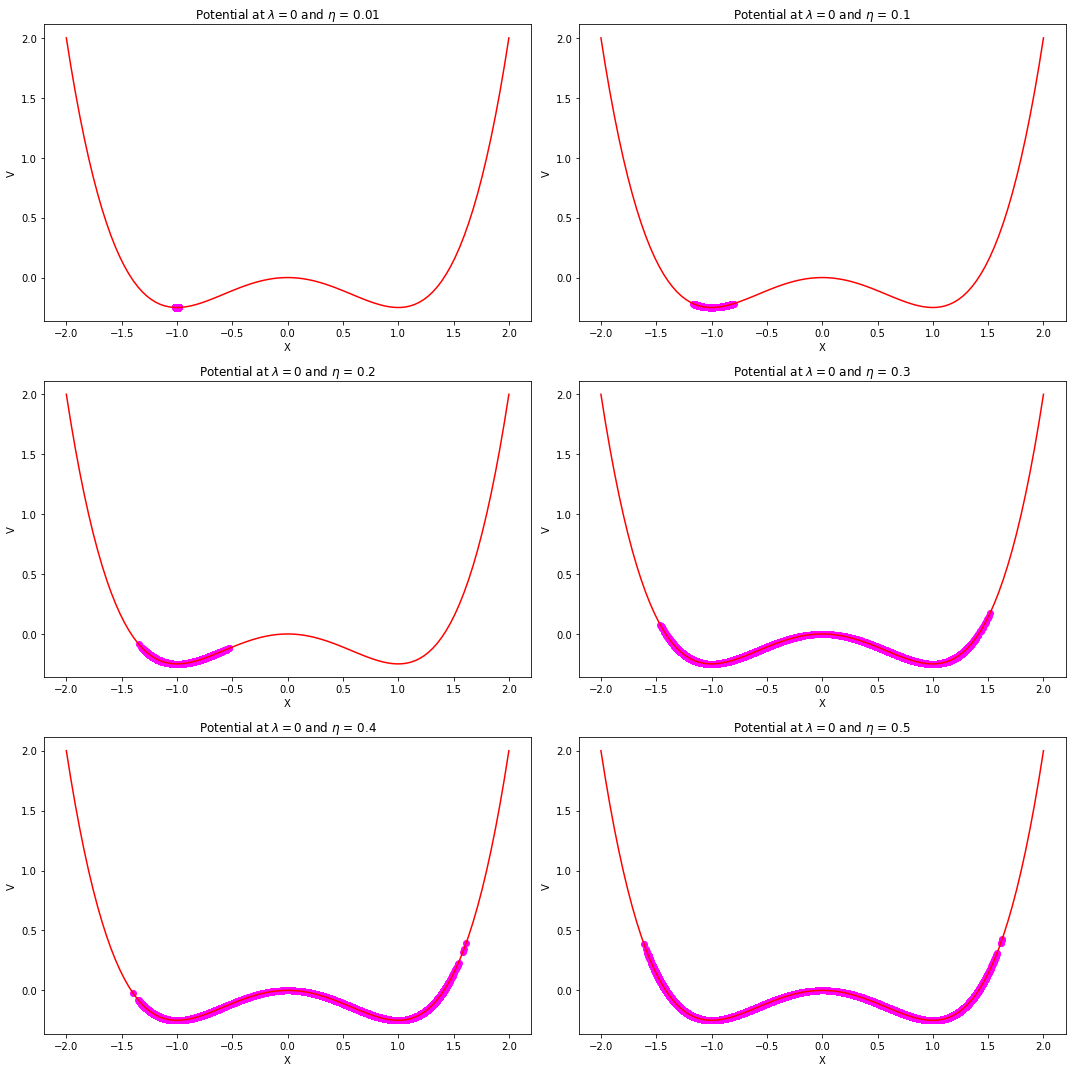

In [7]:
random.seed(454)
noise_levels = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
fig, axes = plt.subplots(3, 2, figsize=(15,15))
dt = 0.01
ic = np.array([-1])
def f(state, t):
    r = 0
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 1000, dt)
for index, ax in enumerate(axes.ravel()):
    gw = lambda y, t: noise_levels[index] * np.identity(ic.shape[0]) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    eta = int(500/dt) # remove transients
    sol = sol[eta:]
    x = np.linspace(-2, 2, 100)
    lam = 0
    ax.plot(x, -lam*x - (x**2)/2 + (x**4)/4, color='red')
    ax.scatter(sol,-lam*sol - (sol**2)/2 + (sol**4)/4, color='magenta')
    ax.set_title('Potential at $\lambda = 0$ and $\eta$ = {}'.format(noise_levels[index]))
    ax.set_xlabel('X')
    ax.set_ylabel('V')
plt.tight_layout()
plt.show()    
    

For low noise levels, the trajectory is confined to one of the local minima and only 'sees' a parabola -> all noisy deviations are returned back to the minimum through a 'restoring force'. As noise level increases, more of the potential is 'explored'. Between noise level 0.3 and 0.4, bistable switching occurs. 

## Plot Histograms in Bistable Region ($\lambda = 0$ as a function of $\eta$)

The histogram for each respective noise-level will give us some indication of how much time the trajectory is 'spending' in each of the local minima -> it also gives us an idea of how much of the potential is 'seen' by the trajectory. Also note that the point at which switching occurs (in terms of noise) will be dependent on ic's. We will fix it at $x_0 = -1$ here.
- Low noise level: we expect to see a unimodal distribution corresponding to the trajectory remaining constrained to one of the local minimums. 
- For moderate noise level: we expect to see a distinct bimodal distribution corresponding to the trajectory switching between branches. The relative heights of the two peaks will give us an indication of how much time the trajectory is lingering in each of the minimums. Peaks are distinct as most of time is spent in either one minimum or the other, with minimal time spent in-between, switching.
- For high noise level: we expect the peaks of the bimodal distribution to become less 'sharp' as more time is spent outside of the local minima, exploring the entire potential. 
- For very high noise level: even less time is spent in the minima - peaks become nearly indistinguishable (no longer have the 'imprint' of the local dynamics in the histogram). Histogram starts to approximate that of the low noise level in that it just sees a parabola.

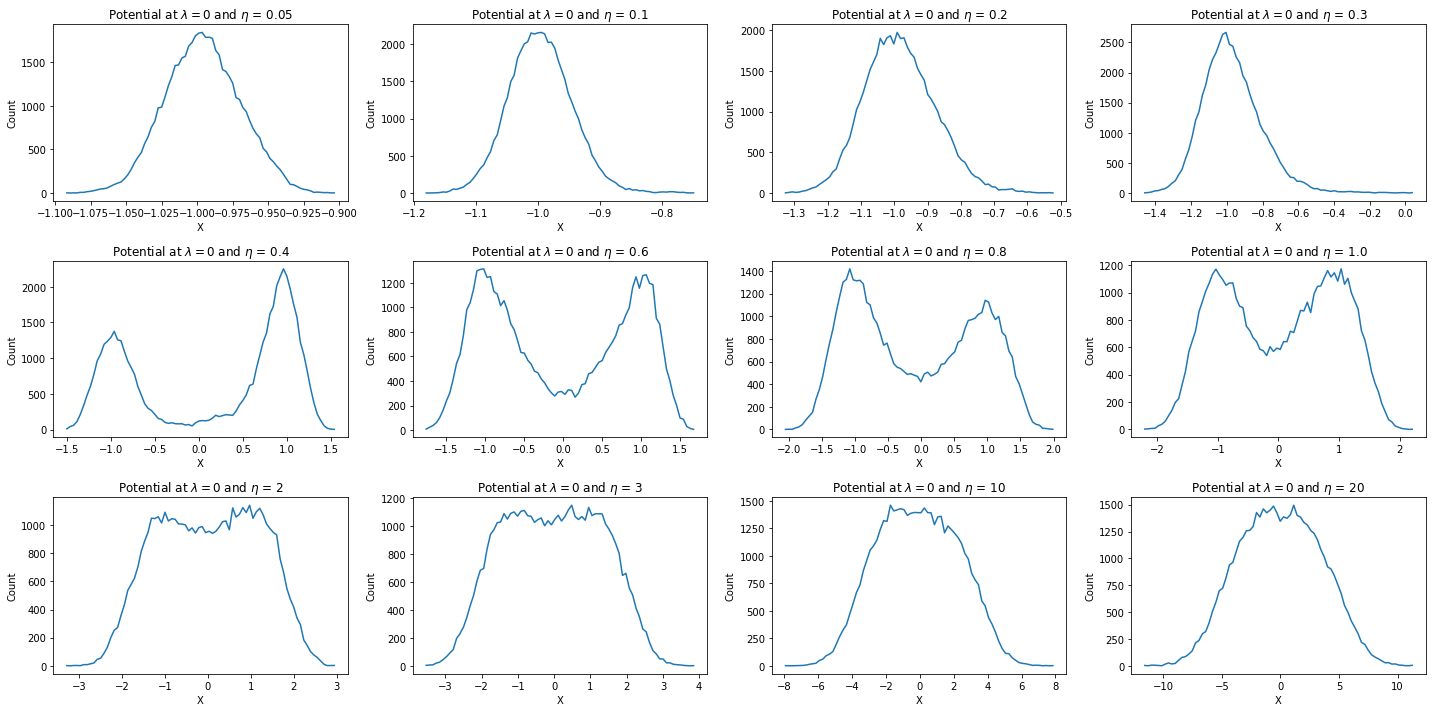

In [8]:
random.seed(454)
etas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1., 2, 3, 10, 20]
fig, axes = plt.subplots(3, 4, figsize=(20,10))
dt = 0.01
ic = np.array([-1])
def f(state, t):
    r = 0
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 1000, dt)
for index, ax in enumerate(axes.ravel()):
    gw = lambda y, t: etas[index] * np.identity(ic.shape[0]) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    eta = int(500/dt) # remove transients
    sol = sol[eta:]
    y, binEdges = np.histogram(sol, bins=80)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters, y)
    ax.set_title('Potential at $\lambda = 0$ and $\eta$ = {}'.format(etas[index]))
    ax.set_xlabel('X')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()    


## Additional notes
- In the low noise regime, as noise increases, the distribution becomes more asymmetric. This is because for very small noise, the potential is approximately quadratic (symmetric), however as noise level increases, more of the potential is explored and it begins to look more like a morse oscillator. The gradient on either side of the local minimum is not the same and deviations from the local minimum are more strongly 'restored' on one side than the other (where the slope is smaller).
- At $\eta = 0.4$, more time is spent in the second minimum as noise is not sufficient drive more frequent switching, thus we get asymmetric peaks. 
- At $\eta = 0.6$, we observe more frequent switching as peaks are roughly the same height (also amount of time spent between peaks due to frequent switching increases as expected).
- At $\eta = 1.0$, the imprint of the local dynamics is still evident, however the peaks have become less distint and broadened as the trajectory spends less and less time in the minima. 
- For $\eta = 3$ and greater, the stochastics clearly dominate and we no longer see the imprint of the local dynamics. Histogram appears somewhat similar to that of low noise confined to a quadratic potential. 


__Question:__ At what noise level does the trajectory spend equal amounts of time in each branch?

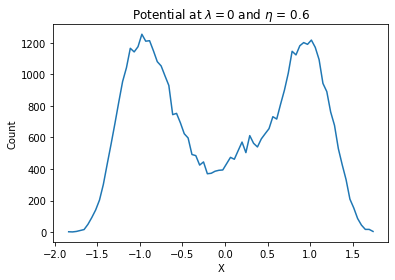

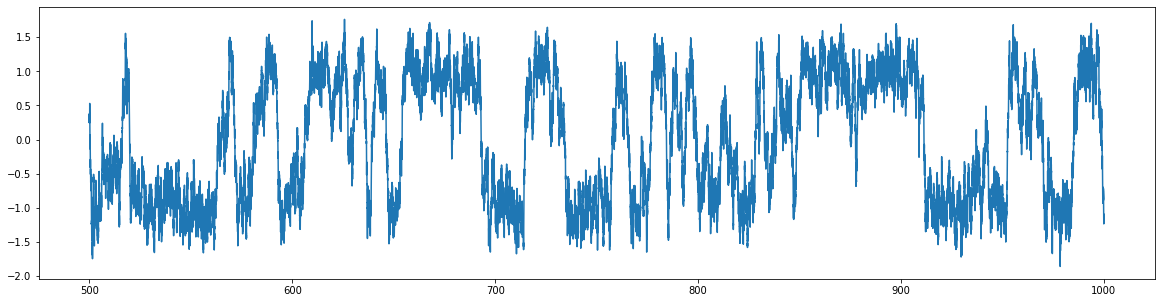

In [9]:
noise = 0.6
dt = 0.01
ic = np.array([-1])
tspan = np.arange(0, 1000, dt)
def f(state, t):
    r = 0
    x = state
    dxdt = r + x - x**3
    return dxdt 
gw = lambda y, t: noise * np.identity(ic.shape[0]) # noise is relative to ic's 
fw = lambda y, t: np.array(f(y,t))
sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
eta = int(500/dt) # remove transients
sol = sol[eta:]
plt.figure()
y, binEdges = np.histogram(sol, bins=80)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters, y)
plt.title('Potential at $\lambda = 0$ and $\eta$ = {}'.format(noise))
plt.xlabel('X')
plt.ylabel('Count')
plt.figure(figsize=(20,5))
plt.plot(tspan[eta:], sol)


## Scanning over $\eta$ and $\lambda$

We will consider 50 equally spaced values of $\lambda$ in range [-1, 1] and 50 equally spaced noise levels $\eta$ = [0.01, 1]. Initial condition wil be fixed at $x_0 = 1$. Final plot will be coloured by noise level.

Setup parameters

In [10]:
etas = np.linspace(0.01, 1, 50)
lambdas = np.linspace(-1, 1, 50)
dt = 0.01
ic = np.array([-1])
tspan = np.arange(0, 1000, dt)

Generate time-series

In [11]:
#np.random.seed(0)
#sols_list = list()
#for r in lambdas:
#    for noise in etas:
#        def f(state, t):
#            x = state
#            dxdt = r + x - x**3
#            return dxdt 
#        gw = lambda y, t: noise * np.identity(ic.shape[0]) # noise is relative to ic's 
#        fw = lambda y, t: np.array(f(y,t))
#        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
#        eta = int(500/dt) # remove transients
#        sol = sol[eta:]
#        sols_list.append(sol)

In [12]:
#TS = [tspan, np.array([sols_list[i][:,0] for i in range(len(sols_list))])]
#FEATURES = np.array([catch22.catch22_all(TS[1][i,:])['values'] for i in range(len(sols_list))])

In [13]:
with open('bistable_TS.pkl', 'rb') as f:
    TS = pickle.load(f)

In [14]:
with open('bistable_TS_FEATURES.pkl', 'rb') as f:
    FEATURES = pickle.load(f)

In [15]:
normalized_features = StandardScaler().fit_transform(FEATURES)
pca_reducer = PCA(n_components=2)
embedding = pca_reducer.fit_transform(normalized_features)

Store every combination of lambda and eta for each of the points

In [16]:
lambdas_plot = np.array([np.repeat(lambdas[i], 50) for i in range(len(lambdas))]).ravel() # 
etas_plot = np.tile(etas, 50)
point_data = np.vstack([lambdas_plot, etas_plot]) # can now use this to look at specific ranges

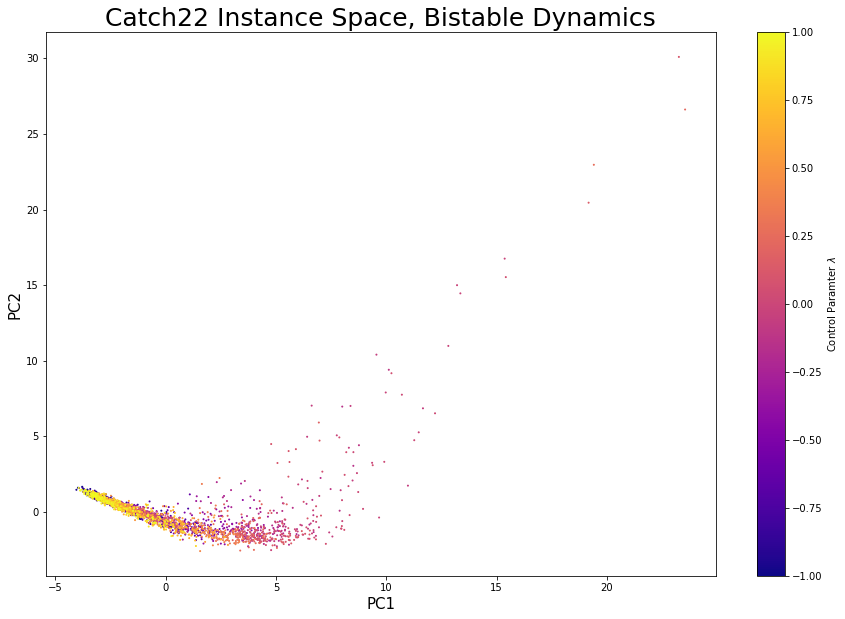

In [17]:
plt.figure(figsize=(15,10))
plt.scatter(embedding[:,0], embedding[:,1], c=lambdas_plot, s=1, cmap='plasma')
plt.title('Catch22 Instance Space, Bistable Dynamics', fontsize=25)
plt.colorbar().ax.set_ylabel('Control Paramter $\lambda$', fontsize=10)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

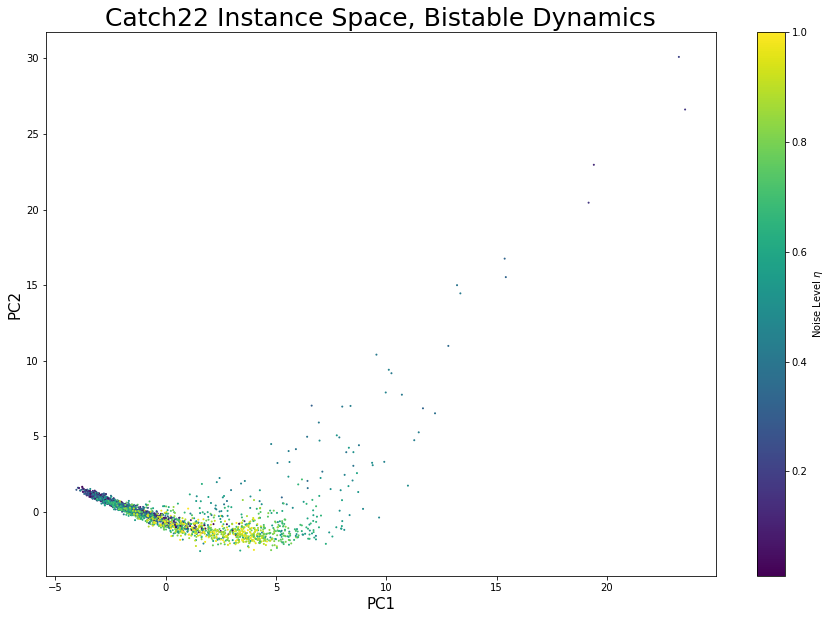

In [18]:
plt.figure(figsize=(15,10))
plt.scatter(embedding[:,0], embedding[:,1], c=etas_plot, s=1, cmap='viridis')
plt.title('Catch22 Instance Space, Bistable Dynamics', fontsize=25)
plt.colorbar().ax.set_ylabel('Noise Level $\eta$', fontsize=10)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

In [19]:
# To do: Set ranges on the different regimes so can examine in detail i.e. set -0.5 to 0.5 as 
# bistable region, -0.5 to -1 as fixed point lower branch and 0.5 to 1 as fixed point upper branch
# make an interactive plot where you can select specific lambdas and etas and dim out the rest
# use the point data array pick out points of interest based on their lambda and eta

In [20]:
def plot_lambdas(lam_index):
    lambda_val = lambdas[lam_index] 
    plt.figure(figsize=(10,6))
    index_vals = (point_data[0] == lambda_val)
    plt.scatter(embedding[:, 0], embedding[:,1], alpha=0.1, color='gray', s=5)
    plt.scatter(embedding[index_vals,0], embedding[index_vals,1], c=etas, s=5, cmap='plasma')
    plt.xlabel('PC1', fontsize=15)
    plt.title('$\lambda = {:.3f}$'.format(lambda_val))
    plt.colorbar().set_label('Noise Amplitude $\eta$')
    plt.ylabel('PC2', fontsize=15)
    #plt.xlim([-5,35])
    #plt.ylim([-5,35])

In [21]:
ipywidgets.interact(plot_lambdas, lam_index=IntSlider(0, 0, 49, 1, layout=Layout(width='500px')))
plt.show()

interactive(children=(IntSlider(value=0, description='lam_index', layout=Layout(width='500px'), max=49), Outpu…

In [22]:
TS[4][:,0].shape

(50000,)

# Inspect Time Series 

In [23]:
def plot_ts(ts_index):
    lam_val, eta_val = point_data[:, ts_index]
    plt.figure(figsize=(20,6))
    sol = TS[ts_index][:,0]
    plt.plot(tspan[eta:], sol)
    plt.title(f'$\lambda = {lam_val:.3f}$, $\eta = {eta_val:.3f}$')
    plt.xlim(left = 500, right=1000)
    plt.ylim(-2, 2)
def plot_hist(ts_index):
    lam_val, eta_val = point_data[:, ts_index]
    plt.figure(figsize=(20,6))
    sol = TS[ts_index][:,0]
    plt.hist(sol, bins=100)
    plt.title(f'$\lambda = {lam_val:.3f}$, $\eta = {eta_val:.3f}$')

In [24]:
ipywidgets.interact(plot_ts, ts_index=IntSlider(0, 0, 2499, 1, layout=Layout(width='1000px')))
plt.show()

interactive(children=(IntSlider(value=0, description='ts_index', layout=Layout(width='1000px'), max=2499), Out…

In [232]:
ipywidgets.interact(plot_ts, ts_index=IntSlider(0, 0, 2499, 1, layout=Layout(width='1000px')))
plt.show()

interactive(children=(IntSlider(value=0, description='ts_index', layout=Layout(width='1000px'), max=2499), Out…

In [25]:
ipywidgets.interact(plot_hist, ts_index=IntSlider(0, 0, 2499, 1, layout=Layout(width='1000px')))
plt.show()

interactive(children=(IntSlider(value=0, description='ts_index', layout=Layout(width='1000px'), max=2499), Out…

## Defining Regimes

There are three primary regions - stable fixed point (lower branch), bistable region, stable fixed point (upper branch)
 - There are sub-regimes within these regions ie. low noise fixed point and noisy fixed point, low noise bistable (qualitatively similar to fixed point) and bistable switching (noise exceeds some threshold for switching to occur - dependent on initial conditions).
 - Bistable region is $\lambda = [-0.384, 0.384]$
 - Fixed point regions are $\lambda = [-1, -0.385]$ (lower branch) and $\lambda = [0.385, 1]$ (upper branch)

In [26]:
fixed_pt_lower = lambdas[lambdas < -0.384]
bistable = lambdas[(lambdas >= -0.384)*(lambdas <= 0.384)]
fixed_pt_upper = lambdas[lambdas > 0.384]

In [27]:
point_data[0, :]

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [28]:
fixed_pt_lower = point_data[0, :] < -0.384
bistable = (point_data[0, :] >= -0.384)*(point_data[0, :] <= 0.384)
fixed_pt_upper = point_data[0, :] > 0.384

## Observe Each in Isolation

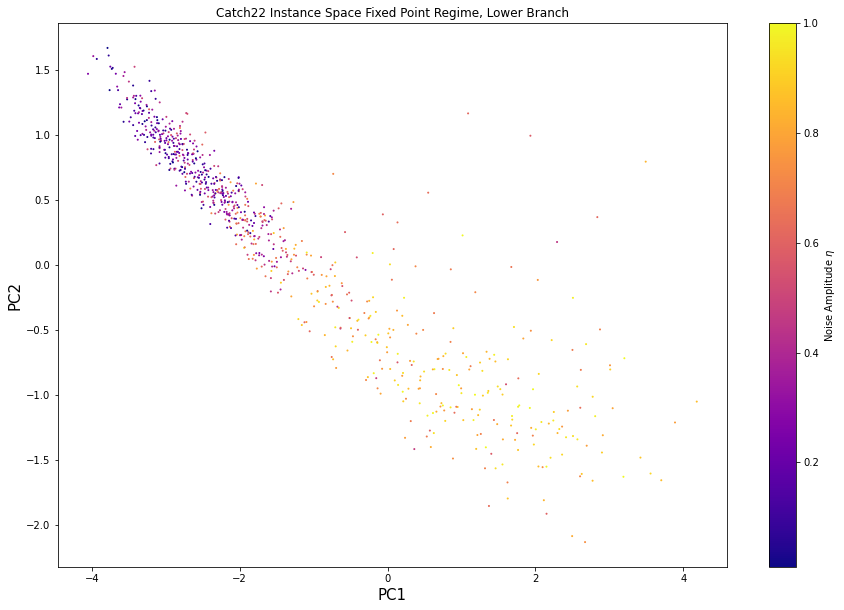

In [29]:
plt.figure(figsize=(15,10))
plt.scatter(embedding[fixed_pt_lower,0], embedding[fixed_pt_lower,1], c=etas_plot[fixed_pt_lower], s=1, cmap='plasma')
plt.title('Catch22 Instance Space Fixed Point Regime, Lower Branch', fontsize=12)
plt.colorbar().ax.set_ylabel('Noise Amplitude $\eta$', fontsize=10)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

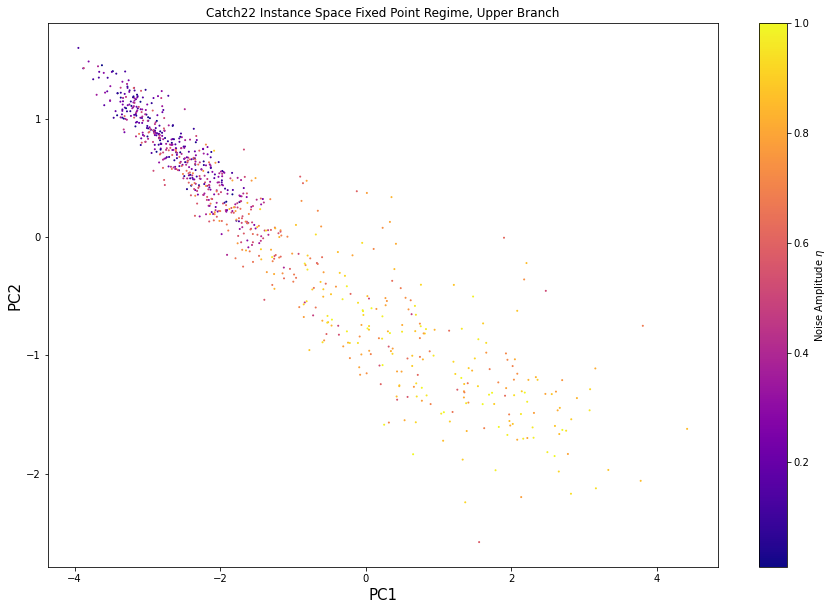

In [30]:
plt.figure(figsize=(15,10))
plt.scatter(embedding[fixed_pt_upper,0], embedding[fixed_pt_upper,1], c=etas_plot[fixed_pt_upper], s=1, cmap='plasma')
plt.title('Catch22 Instance Space Fixed Point Regime, Upper Branch', fontsize=12)
plt.colorbar().ax.set_ylabel('Noise Amplitude $\eta$', fontsize=10)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

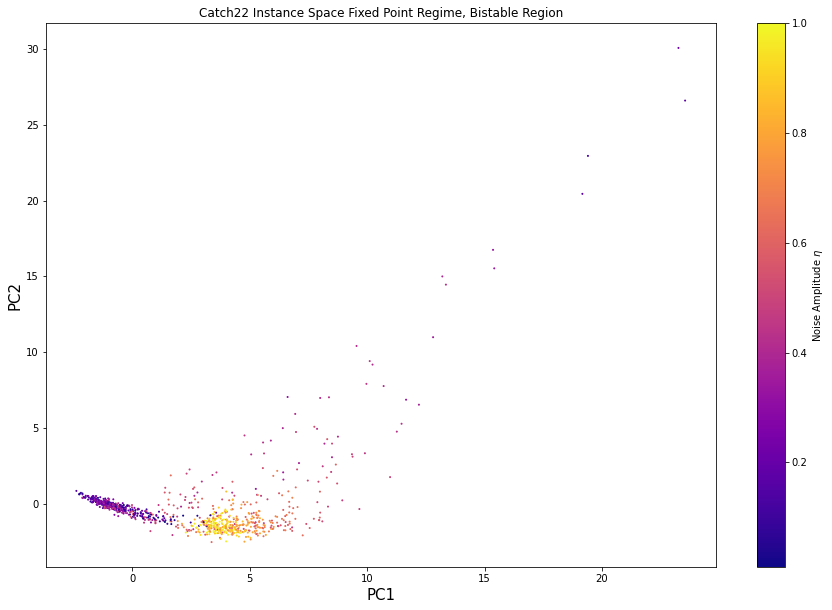

In [31]:
plt.figure(figsize=(15,10))
plt.scatter(embedding[bistable,0], embedding[bistable,1], c=etas_plot[bistable], s=1, cmap='plasma')
plt.title('Catch22 Instance Space Fixed Point Regime, Bistable Region', fontsize=12)
plt.colorbar().ax.set_ylabel('Noise Amplitude $\eta$', fontsize=10)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

## Plotly Version of Instance Space

Construct a dataframe (something I should have done a long time ago)

In [124]:
df = pd.DataFrame(embedding)
df['lam'] = lambdas_plot
df['eta'] = etas_plot
df.head()

,0,1,lam,eta
0,-3.788070,1.673018,-1.0,0.010000
1,-3.522426,1.276828,-1.0,0.030204
2,-3.570654,1.104603,-1.0,0.050408
3,-3.280221,0.947657,-1.0,0.070612
4,-3.441207,1.078773,-1.0,0.090816


In [125]:
# define function to apply categorical labels
def label_region(row):
    if row['lam'] < -0.384:
        return 'Fixed Point (Lower Branch)' # fixed point lower branch
    if row['lam'] >= -0.384 and row['lam'] <=0.384:
        return 'Bistable' # Bistable region
    if row['lam'] > 0.384:
        return 'Fixed Point (Upper Branch)' # Fixed point upper branch

In [126]:
df['regime'] = df.apply(lambda row: label_region(row), axis=1)
df.head()

,0,1,lam,eta,regime
0,-3.788070,1.673018,-1.0,0.010000,Fixed Point (Lower Branch)
1,-3.522426,1.276828,-1.0,0.030204,Fixed Point (Lower Branch)
2,-3.570654,1.104603,-1.0,0.050408,Fixed Point (Lower Branch)
3,-3.280221,0.947657,-1.0,0.070612,Fixed Point (Lower Branch)
4,-3.441207,1.078773,-1.0,0.090816,Fixed Point (Lower Branch)


In [127]:
fig = px.scatter(df, x=0, y=1, color=lambdas_plot, 
    labels={'0': 'PC1', '1': 'PC2', 'color': r"$\lambda$"}, width=900, height=800, custom_data=['lam', 'eta', 'regime'])
fig.update_traces(
    hovertemplate="<br>".join([
        "Lambda: %{customdata[0]:.3f}",
        "Eta: %{customdata[1]:.3f}",
        "Regime: %{customdata[2]}"
    ])
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title_text='Catch22 Instance Space, Bistable System', title_x=0.5)
fig.show()

## Experiment with t-SNE

In [279]:
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

#### Load in saved list of extracted features from earlier

In [128]:
with open('bistable_TS_FEATURES.pkl', 'rb') as f:
    FEATURES = pickle.load(f)

##### Main hyperparameter to tune is the 'perplexity' (# of neighbours)

In [257]:
normalized_features = StandardScaler().fit_transform(FEATURES)

In [307]:
PCA_reducer = PCA(n_components=10)
pca_reduced_data = pca_reducer.fit_transform(normalized_features)

In [317]:
embedding_TSNE = TSNE(n_components=2,perplexity = 45, verbose = 0, learning_rate = 'auto', init='random', random_state=0, n_iter=5000).fit_transform(pca_reduced_data)

In [318]:
df_tsne = pd.DataFrame(embedding_TSNE)
df_tsne['lam'] = lambdas_plot
df_tsne['eta'] = etas_plot
df_tsne['regime'] = df.apply(lambda row: label_region(row), axis=1)
df_tsne.head()

,0,1,lam,eta,regime
0,22.216442,-43.510098,-1.0,0.010000,Fixed Point (Lower Branch)
1,49.040520,16.645931,-1.0,0.030204,Fixed Point (Lower Branch)
2,45.574932,-20.717396,-1.0,0.050408,Fixed Point (Lower Branch)
3,36.634106,0.819667,-1.0,0.070612,Fixed Point (Lower Branch)
4,39.008148,0.269673,-1.0,0.090816,Fixed Point (Lower Branch)


In [319]:
fig = px.scatter(df_tsne, x=0, y=1, color=df_tsne['regime'], 
    labels={'0': 't-SNE1', '1': 't-SNE2', 'color': r"$\lambda$"}, width=900, height=800, custom_data=['lam', 'eta', 'regime'])
fig.update_traces(
    hovertemplate="<br>".join([
        "Lambda: %{customdata[0]:.3f}",
        "Eta: %{customdata[1]:.3f}",
        "Regime: %{customdata[2]}"
    ])
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title_text='Catch22 Instance Space, Bistable System', title_x=0.5)
fig.show()